In [17]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
import phik
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from ctgan import CTGAN
from sklearn.preprocessing import KBinsDiscretizer
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
pd.set_option('display.float_format', '{:.2f}'.format)

<h1>Fixing the Regression</h1>


<b>Summary from the report</b>
<ul>
<li>Remove from the List</li>
<li>Cap the outliers, especially for the 6 focused on columns</li>
<li>Next Homework, fix distribution with synthetic Data for the ones where autovizviz, ydata and SHAP say the importance is higher (only for the kept columns, maybe redo all the reports with the cut down data)</li>
</ul>

In [19]:
df = pd.read_csv("Clean_Zillow.csv")
df.head()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,state,yearBuilt,latitude,rentZestimate,city,zestimateLowPercent,...,bedrooms,price,zestimateHighPercent,homeType_APARTMENT,homeType_CONDO,homeType_LOT,homeType_MANUFACTURED,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE
0,-149.91,2020.00,0.00,2840,AK,1959.00,61.22,3142.00,Anchorage,12.00,...,3.00,676100,13.00,0,0,0,0,0,1,0
1,-149.91,2020.00,0.00,2934,AK,1961.00,61.22,3113.00,Anchorage,12.00,...,3.00,698600,13.00,0,0,0,0,0,1,0
2,-149.91,2020.00,0.00,4187,AK,1983.00,61.22,4282.00,Anchorage,12.00,...,4.00,996800,14.00,0,0,0,0,0,1,0
3,-149.91,2020.00,0.00,2920,AK,1947.00,61.22,3458.00,Anchorage,15.00,...,5.00,695300,16.00,0,0,0,0,0,1,0
4,-149.91,2020.00,0.00,4100,AK,2000.00,61.22,4161.00,Anchorage,18.00,...,4.00,976100,24.00,0,1,0,0,0,0,0


<b>Removing</b>

In [20]:
dropable=["state","city",'yearBuilt','zestimateLowPercent','zestimate','zestimateHighPercent','latitude','zipcode','timeOnZillow']
df=df.drop(dropable,axis=1)


X = df.drop(["price"], axis=1)
y = df['price']


<b>Combining</b>

In [21]:
#Chatgpt
# Example: Combine the sparse columns into an "Other" category
sparse_columns = ['homeType_LOT', 'homeType_MANUFACTURED', 'homeType_APARTMENT','homeType_TOWNHOUSE','homeType_MULTI_FAMILY']

# Create a new 'Other' column that combines the sparse categories
df['homeType_OTHER'] = df[sparse_columns].sum(axis=1)

# Drop the original sparse columns
df = df.drop(columns=sparse_columns)

# Check the updated DataFrame
df.head()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
0,-149.91,2020.00,0.00,2840,3142.00,2668.00,1.31,2.00,3.00,676100,0,1,0
1,-149.91,2020.00,0.00,2934,3113.00,3179.00,1.31,2.00,3.00,698600,0,1,0
2,-149.91,2020.00,0.00,4187,4282.00,3059.00,1.31,3.00,4.00,996800,0,1,0
3,-149.91,2020.00,0.00,2920,3458.00,1642.00,1.31,2.00,5.00,695300,0,1,0
4,-149.91,2020.00,0.00,4100,4161.00,4483.00,1.31,4.00,4.00,976100,1,0,0


<b>Cap/Outlier Removal</b>

<b>Distribution</b>

In [22]:
#Distribution of the Focused on variable
#Focused Variables are:
#rentZestimate, livingArea, propertyTaxRate, bathrooms, bedrooms, price

<b>Property Tax Rate</b>

<Axes: xlabel='propertyTaxRate', ylabel='Count'>

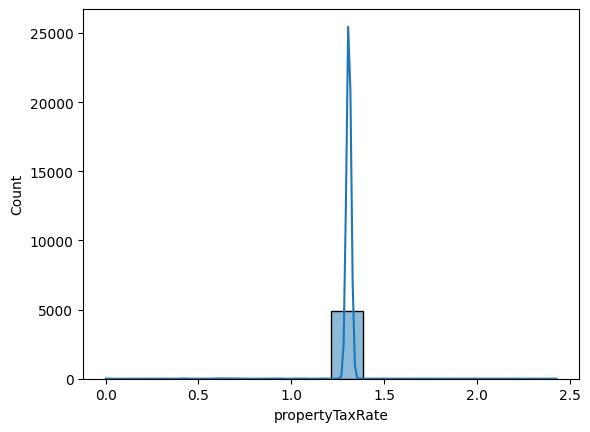

In [23]:
sns.histplot(data=df, x="propertyTaxRate", kde=True)

In [ ]:
#we have 5k houses, so i will use SMOTE and then undersample
# after some consideration first undersampeling then ctgan is better

In [34]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Define the target variable
target = "propertyTaxRate"

# Apply Isolation Forest
iso = IsolationForest(contamination=0.1) 
df['outlier'] = iso.fit_predict(df[[target]])  # Fit on the target variable
y_pred = iso.fit_predict(df)

# filter outliers only
outliers = df[y_pred != 1]
df_undersampled = df.drop(outliers.index)

<Axes: xlabel='propertyTaxRate', ylabel='Count'>

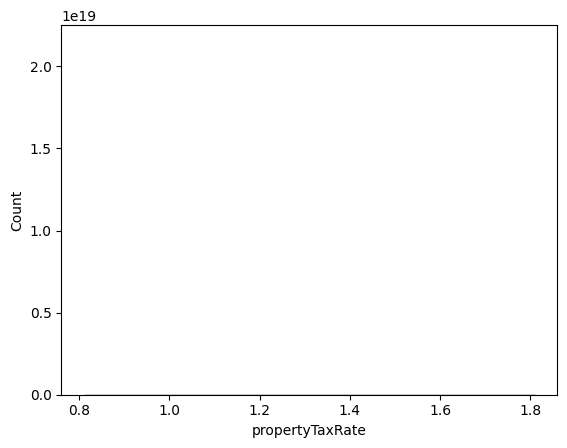

In [35]:
sns.histplot(data=df_undersampled, x="propertyTaxRate", kde=True)

<Axes: >

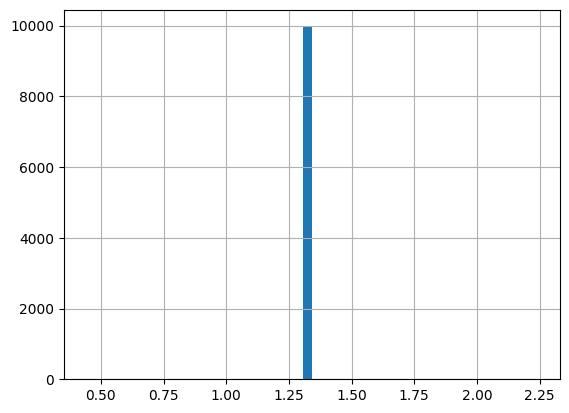

In [25]:

# Target variable
target = "propertyTaxRate"

# Full dataset for training CTGAN
ctgan = CTGAN(epochs=100)  # Specify the number of epochs for training
ctgan.fit(df)  # Train the CTGAN model on the dataset

# Generate synthetic data
num_new_data = 10000  # Number of synthetic rows to generate
synthetic_data = ctgan.sample(num_new_data)

# Convert the synthetic data to a Pandas DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)

# Inspect the distribution of the generated 'propertyTaxRate'
synthetic_df[target].hist(bins=50)  # Plot the synthetic distribution


<Axes: xlabel='propertyTaxRate', ylabel='Count'>

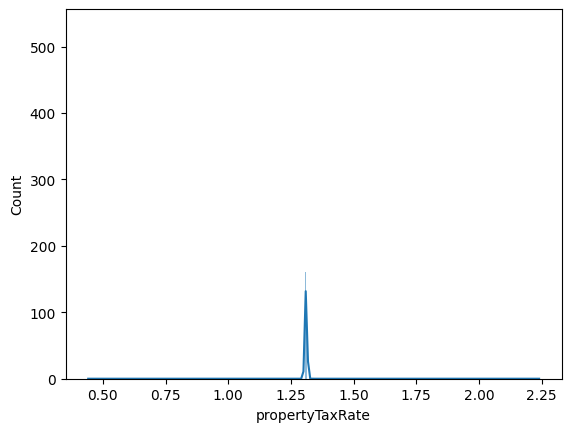

In [26]:
sns.histplot(data=synthetic_df, x="propertyTaxRate", kde=True)

<b>Finished Product</b>


In [27]:
df.to_csv('fixed_Zillow.csv', index=False)